In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

## New topic: double gaussian psf...

1.0


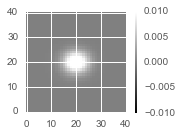

In [3]:
reload(dit)
psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.psf.doubleGaussian2d(x0, y0, 0, 0, a=0.9, sigma_x=3.0, sigma_y=3.5)
print psf.sum()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

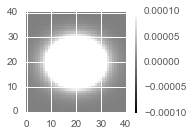

In [4]:
dit.plotImageGrid((psf,), clim=(-0.0001, 0.0001))

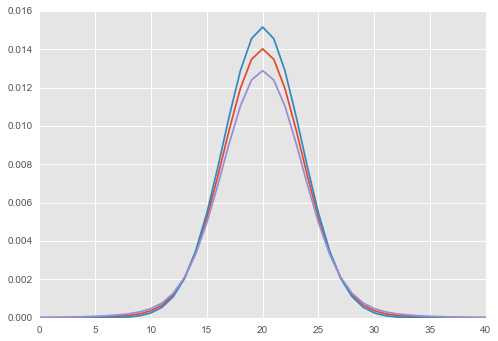

In [5]:
psf2 = dit.psf.singleGaussian2d(x0, y0, 0, 0, sigma_x=3.0, sigma_y=3.5, theta=0.)
psf3 = dit.psf.doubleGaussian2d(x0, y0, 0, 0, a=0.8, sigma_x=3.0, sigma_y=3.5)
plt.plot(psf[20,:])
plt.plot(psf2[20,:])
plt.plot(psf3[20,:])

## Use `galsim` for Kolmogorov PSF...

705600
galsim.BoundsI(1,840,1,840) 840


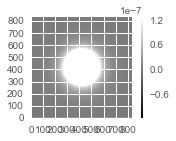

In [17]:
import galsim
gsp = galsim.GSParams(folding_threshold=1.0/512., maximum_fft_size=12288)
psf = galsim.Kolmogorov(fwhm=3.5*2.355, flux=1, gsparams=gsp)
im = psf.drawImage(method='real_space', scale=0.2)
#print psf.flux
print im.image.array.size
bounds = im.getBounds()
print bounds, bounds.getXMax()
arr = im.image.array.reshape(bounds.getXMax(), bounds.getXMax())
dit.plotImageGrid((arr,))

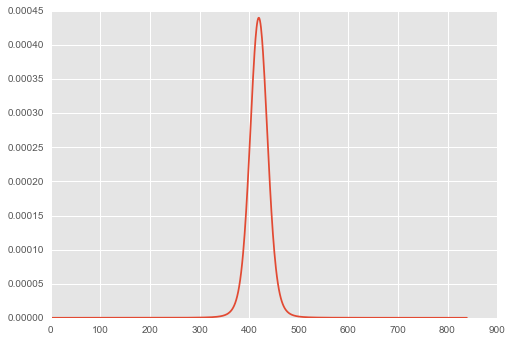

In [18]:
plt.plot(arr[bounds.getXMax()//2,:])

## Now a Moffat...

1.0


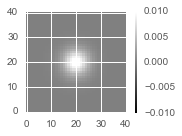

In [8]:
reload(dit)

psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.psf.moffat2d(x0, y0, 0, 0, 3.5*2.355)  # fwhm = 2.355 * sigma
print psf.sum()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

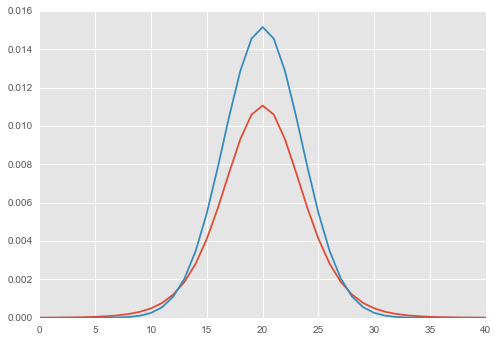

In [9]:
plt.plot(psf[20,:])
plt.plot(psf2[20,:])

## After adding these to `diffimTests.psf.makePsf` and `diffimTests.makeFakeImages`...

In [10]:
reload(dit)
testObj = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 3, 'FN': 461, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 461, 'TP': 39}, 'SZOGY': {'FP': 1, 'FN': 460, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 461, 'TP': 39}}


In [11]:
reload(dit)
testObj2 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType='doubleGaussian')

res2 = testObj2.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src2 = res2['sources']
del res2['sources']
print res2

{'ZOGY': {'FP': 0, 'FN': 463, 'TP': 37}, 'ALstack': {'FP': 0, 'FN': 463, 'TP': 37}, 'SZOGY': {'FP': 2, 'FN': 465, 'TP': 35}, 'ALstack_decorr': {'FP': 0, 'FN': 463, 'TP': 37}}


In [12]:
reload(dit)
testObj3 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType='moffat')

res3 = testObj3.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src3 = res3['sources']
del res3['sources']
print res3

{'ZOGY': {'FP': 2, 'FN': 463, 'TP': 37}, 'ALstack': {'FP': 0, 'FN': 463, 'TP': 37}, 'SZOGY': {'FP': 3, 'FN': 464, 'TP': 36}, 'ALstack_decorr': {'FP': 0, 'FN': 463, 'TP': 37}}


In [13]:
tmp = dit.catalogToDF(testObj2.getCentroidsCatalog(transientsOnly=False))
dit.sizeme(tmp.tail())

,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
495,30.372440,468.217864,0.927905,3.761396,496,5119.095845,5119.095845,0
496,281.360109,454.797086,0.927914,3.761769,497,3515.021250,3515.021250,0
497,120.501169,434.522680,0.927934,3.761529,498,2651.422731,2651.422731,0
498,480.043574,88.493723,0.928237,3.762062,499,5623.537396,5623.537396,0
499,30.651520,419.162954,0.927949,3.761396,500,6786.443544,6786.443544,0


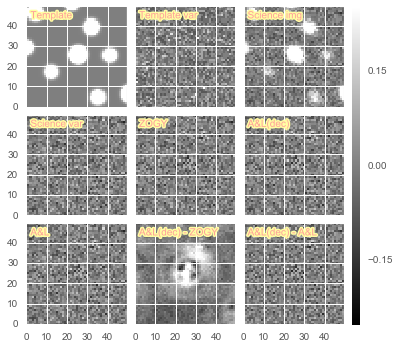

In [14]:
testObj.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

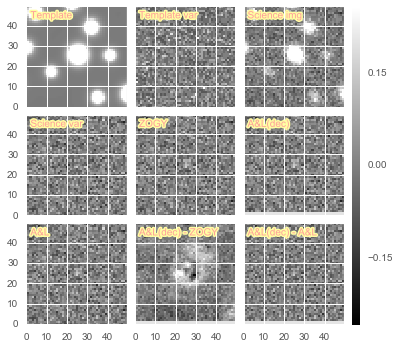

In [15]:
testObj2.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

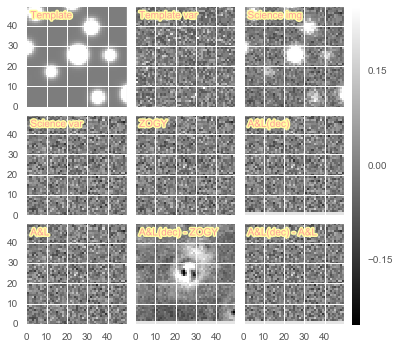

In [16]:
testObj3.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);